In [2]:
from ProjectTools import OpenBeds
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import upsetplot
from upsetplot import from_memberships

dry = False

def filterDepth(df):
    average = df["readCount"].mean()
    df = df[df["readCount"].ge(10)]
    df = df[df["readCount"].le(average + 3*math.sqrt(average))]
    # df = df.loc[df["readCount"] == 15] # Testing constant readcount
    return df

if dry == True:
    nano_2mod_path = './test_data/prom_R10.4.1_E8.2_WGS_brain_DH_5mC_nonAggregated_sub.bedMethyl'
    nano_3mod_path = './test_data/prom_R10.4.1_E8.2_WGS_brain_0.9.1_mods_sub.bed'
    tab_path = './test_data/CRR008807_TAB_merged.bedGraph.gz.bismark.zero.cov_sub.bed'
    
    nano_3mod_mc, nano_3mod_hmc = map(filterDepth, OpenBeds.get_nanopore_threeMod_wStrand(nano_3mod_path))
    
    nano_2mod = filterDepth(OpenBeds.get_nanopore_twoMod(nano_2mod_path))
    tab_df = filterDepth(OpenBeds.get_tab(tab_path))

else:
    nano_2mod_path = './data/prom_R10.4.1_E8.2_WGS_brain_DH_5mC_nonAggregated.bedMethyl'
    nano_3mod_path = './data/prom_R10.4.1_E8.2_WGS_brain_0.9.1_mods.bed'
    tab_path = './data/TAB_data/CRR008807_TAB_merged.bedGraph.gz.bismark.zero.cov'

    nano_3mod_mc, nano_3mod_hmc = map(filterDepth, OpenBeds.get_nanopore_threeMod_wStrand(nano_3mod_path))
    
    nano_2mod = filterDepth(OpenBeds.get_nanopore_twoMod(nano_2mod_path))
    tab_df = filterDepth(OpenBeds.get_tab(tab_path))

In [3]:
from pybedtools import BedTool

names=["chromosome", "chromStart", "chromEnd", "modification_type", "readCount", "percentMeth", "method", ".", ".1", ".2", "strand"]
tab_strands_df = BedTool.intersect(BedTool.from_dataframe(tab_df), 
                                   BedTool('./data/CRR008807_TAB_cytosine_report.tsv.CpG_report_strands.bed'), wb=True).to_dataframe(names=names).drop(columns=[".", ".1", ".2"])
tab_strands_df = tab_strands_df[["chromosome", "chromStart", "chromEnd", "strand", "modification_type", "readCount", "percentMeth", "method"]]

In [4]:
import numpy as np

def filterMods(df):
    return df.loc[df["percentMeth"] == 100]

def filterHemiMods(df): 
    return df.loc[(df["percentMeth"] < 100) & (df["percentMeth"] > 0)]

def filterNoMods(df): 
    return df.loc[df["percentMeth"] == 0]

def nonZeroMod(df):
    return df.loc[df["percentMeth"] > 0]

def filterIntersect(df1, df2):
    df1["method"], df2["method"] = "Nanopore", "Nanopore"
    df1, df2 = map(filterHemiMods, [df1, df2])
    return pd.merge(df1, df2, "inner", on=["chromosome", "chromStart", "chromEnd", "strand", "readCount"])

def noModsAtAll(df1, df2):
    df1["method"], df2["method"] = "Nanopore", "Nanopore"
    df1, df2 = map(filterNoMods, [df1, df2])
    return pd.merge(df1, df2, "inner", on=["chromosome", "chromStart", "chromEnd", "strand", "readCount"])

def modUnmodIntersect(present, absent):
    present["method"], absent["method"] = "Nanopore", "Nanopore"
    intersect = filterHemiMods(present)
    exclusion = filterNoMods(absent)
    return  pd.merge(intersect, exclusion, "inner", on=["chromosome", "chromStart", "chromEnd", "strand", "readCount"])

def modIntersect(df1, df2):
    df1["method"], df2["method"] = "Nanopore", "Nanopore" 
    hemi_df1, hemi_df2 = filterHemiMods(df1), filterHemiMods(df2), 
    intersect = pd.merge(hemi_df1, hemi_df2, "inner", on=["chromosome", "chromStart", "chromEnd", "strand", "readCount"])
    return intersect.loc[intersect[["percentMeth_x", "percentMeth_y"]].sum(axis=1) == 100]

def totalOverlap(df1, df2):
    df1["method"], df2["method"] = "Nanopore", "Nanopore" 
    hemi_df1, hemi_df2 = filterHemiMods(df1), filterHemiMods(df2), 
    intersect = pd.merge(hemi_df1, hemi_df2, "inner", on=["chromosome", "chromStart", "chromEnd", "strand", "readCount"])
    return intersect.loc[intersect[["percentMeth_x", "percentMeth_y"]].sum(axis=1) != 100]

def calculateModRatio(df1, df2):
    merged_df = pd.merge(df1, df2, "inner", on=["chromosome", "chromStart", "chromEnd", "strand", "readCount"])
    mod1, mod2 = df1["modification_type"][0], df2["modification_type"][0]
    merged_df["{mod1}_to_{mod2}_ratio".format(mod1=mod1, mod2=mod2)] = merged_df["percentMeth_x"].div(merged_df["percentMeth_y"], axis=0)
    merged_df.loc[merged_df["{mod1}_to_{mod2}_ratio".format(mod1=mod1, mod2=mod2)] == math.inf, "{mod1}_to_{mod2}_ratio".format(mod1=mod1, mod2=mod2)] = None

    return merged_df[["chromosome", "chromStart", "chromEnd", "readCount", "{mod1}_to_{mod2}_ratio".format(mod1=mod1, mod2=mod2), "strand"]].dropna()

def calculateModOtherRatios(df1, df2=None):
    if df1["method"].str.contains("TAB").all():
        df1["percentOther"] = 100 - df1["percentMeth"]
        df1["5hmC_to_other_ratio"] = np.divide(df1["percentMeth"], df1["percentOther"])
        return df1[["chromosome", "chromStart", "chromEnd", "readCount", "5hmC_to_other_ratio", "strand"]].dropna()
    else:
        merged_df = pd.merge(df1, df2, "inner", on=["chromosome", "chromStart", "chromEnd", "strand", "readCount"])
        mod1 = df1["modification_type"][0]
        merged_df["percentOther"] = 100 - merged_df["percentMeth_x"] # ratio 5hmC to other
        merged_df["{mod1}_to_other_ratio".format(mod1=mod1)] = np.divide(merged_df["percentMeth_x"], merged_df["percentOther"])
        merged_df.loc[merged_df["{mod1}_to_other_ratio".format(mod1=mod1)] == math.inf, ["{mod1}_to_other_ratio".format(mod1=mod1)]] = None

        return merged_df[["chromosome", "chromStart", "chromEnd", "readCount", "{mod1}_to_other_ratio".format(mod1=mod1), "strand", ]].dropna()

In [5]:
def geneIntersect(ratio_df, gene_path):
    """
    Note: Strand must be located on the same column in both bed files. 
    """
    gene_ref_bed = BedTool(gene_path)
    ratio_bed = BedTool.from_dataframe(ratio_df)

    intersect = ratio_bed.intersect(gene_ref_bed, wb=True, s=True)
    names = ["chromosome", "chromStart", "chromEnd", "readCount", "ratio", "strand", "dupChrom", "thickStart", "thickEnd", "gene_name", "Foo", "dupStrand"]
    redundant_cols = ["dupChrom", "thickStart", "thickEnd", "Foo", "dupStrand"]
    return intersect.to_dataframe(names=names).drop(columns=redundant_cols, errors="ignore")

In [6]:
def geneGroup(gene_intersected_df):
    genes_df = pd.DataFrame(gene_intersected_df.groupby(by=["gene_name"])["ratio"].mean()).reset_index()
    genes_df["CpG_count"] = gene_intersected_df.groupby(by=["gene_name"])["chromStart"].count().to_numpy()
    return genes_df

In [7]:
def calculateLog2(df):
    df["log2"] = np.log2(df["ratio"])
    return df

In [8]:
tab_genes_df = calculateLog2(geneGroup(
    geneIntersect(
    calculateModOtherRatios(tab_strands_df), 
    './feature_references/fig5_features/mm39_RefSeqC_select_merged_modified.bed')))
nano_genes_df = calculateLog2(geneGroup(
    geneIntersect(
    calculateModOtherRatios(nano_3mod_hmc, nano_3mod_mc), 
    './feature_references/fig5_features/mm39_RefSeqC_select_merged_modified.bed')))

/u/n/doh28/.conda/envs/NanoporeEvaluationVenv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/u/n/doh28/.conda/envs/NanoporeEvaluationVenv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [9]:
histplot_df = pd.merge(tab_genes_df, nano_genes_df, "outer", on="gene_name", suffixes=["_TAB", "_Nano"])
stripplot_df = pd.wide_to_long(histplot_df, stubnames=["log2", "ratio", "CpG_count"], sep="_", i="gene_name", j="method", suffix="\D+")

histplot_df["log2_difference"] = np.subtract(histplot_df["log2_TAB"], histplot_df["log2_Nano"])

In [42]:
tab = histplot_df.loc[(histplot_df["CpG_count_TAB"] >= 50 ) & (histplot_df["CpG_count_Nano"] >= 50)].sort_values(by=["ratio_TAB"], ascending=False).head(50)

In [43]:
nano = histplot_df.loc[(histplot_df["CpG_count_TAB"] >= 50 ) & (histplot_df["CpG_count_Nano"] >= 50)].sort_values(by=["ratio_Nano"], ascending=False).head(50)

In [51]:
pd.merge(tab, nano, "inner").sort_values("log2_difference", ascending=True).to_excel('./top_hmc_genes.xlsx')

In [12]:
upsetplot_ds = from_memberships(
    [["C"], 
    ["5mC"],
    ["C", "5mC"],
    ["5hmC"],
    ["5mC", "5hmC"],
    ["C", "5hmC"],
    ["C", "5mC", "5hmC"],
    ],
    data = [
        len(noModsAtAll(nano_3mod_mc, nano_3mod_hmc)), 
        len(filterMods(nano_3mod_mc)), 
        len(modUnmodIntersect(nano_3mod_mc, nano_3mod_hmc)), 
        len(filterMods(nano_3mod_hmc)), 
        len(modIntersect(nano_3mod_mc, nano_3mod_hmc)), 
        len(modUnmodIntersect(nano_3mod_hmc, nano_3mod_mc)), 
        len(totalOverlap(nano_3mod_mc, nano_3mod_hmc))
    ]
)
upset = upsetplot.UpSet(upsetplot_ds, show_percentages=True, totals_plot_elements=4, facecolor="tab:blue", element_size=None, sort_categories_by="-input")

/tmp/ipykernel_1619581/2369688495.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=1)


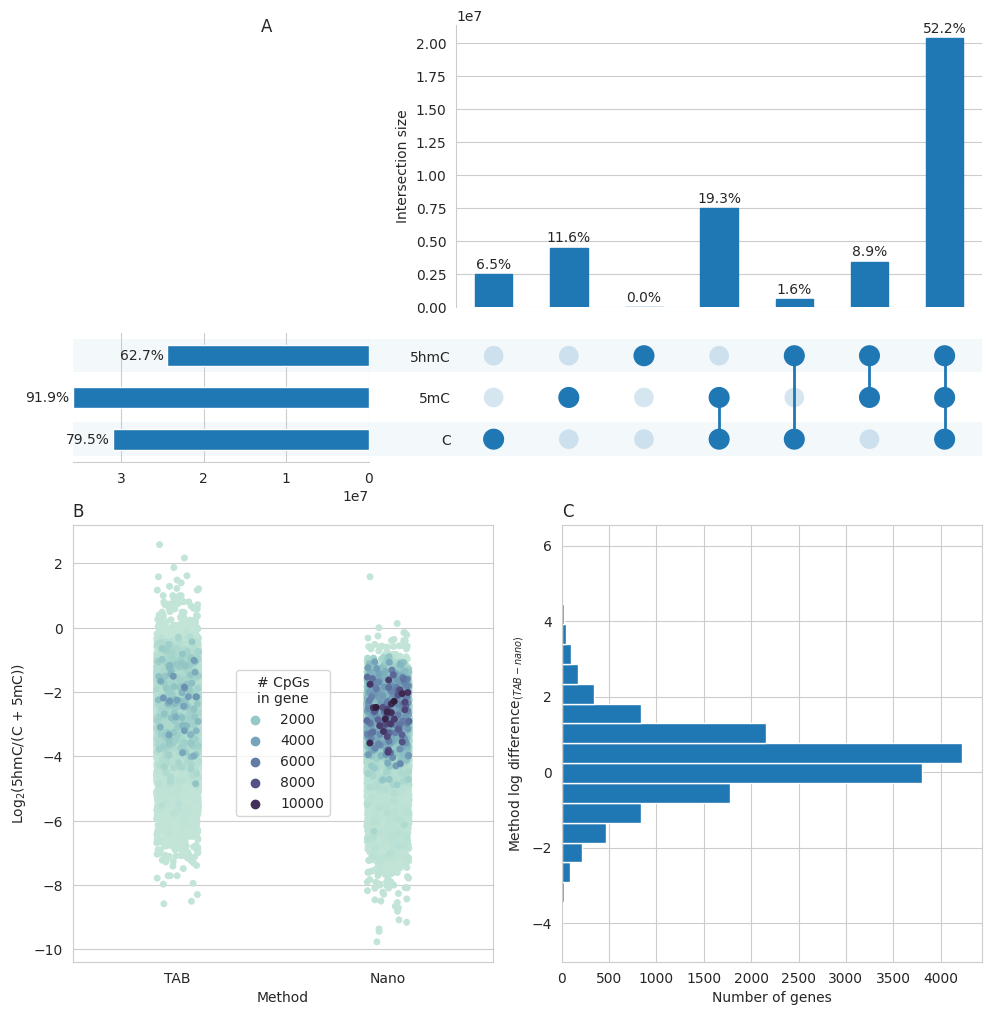

In [30]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

sns.set_style("whitegrid")

fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(2, 2, fig)

fig1 = fig.add_subfigure(gs[0, :])
upset.plot(fig1)
fig1.suptitle("A", x=0.27, y=1)

fig2 = fig.add_subfigure(gs[1, :])
gs2 = gridspec.GridSpec(1, 2)
ax2 = fig2.add_subplot(gs2[0, 0])

sns.stripplot(stripplot_df.sort_values("CpG_count", ascending=True), x="method", y="log2", hue="CpG_count", ax=ax2, palette=sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True))
ax2.set_title("B", loc="left")
ax2.set_ylabel("Log$_{2}$(5hmC/(C + 5mC))")
ax2.set_xlabel("Method")
sns.move_legend(ax2, "center", title="# CpGs\nin gene")


ax3 = fig2.add_subplot(gs2[0, 1])

sns.histplot(histplot_df, y="log2_difference", ax=ax3, bins=20, color="tab:blue", alpha=1)
ax3.set_title("C", loc="left")
ax3.set_ylabel("Method log difference$_{(TAB - nano)}$")
ax3.set_xlabel("Number of genes")

fig.tight_layout(pad=1)
